In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

### Priprava podatkov

In [2]:
lj_dez = pd.read_csv("../ljubljana_dez_2010_2023.csv")

# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, pri katerih je količina padlega dežja vsaj 1.0 mm/h.

In [3]:
# Maska za dež
rain_mask = (lj_dez['SkupenDez'] < 1.0)

lj_dez = lj_dez[rain_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

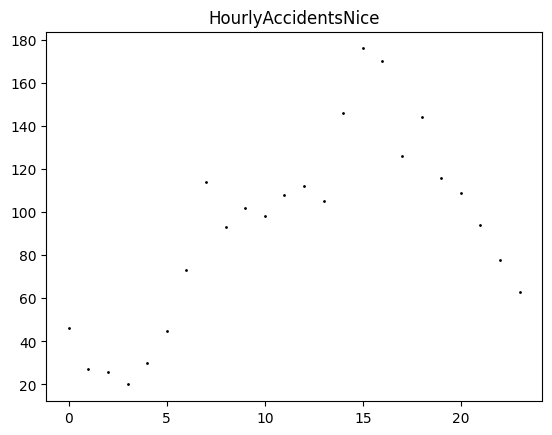

In [4]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNice"])

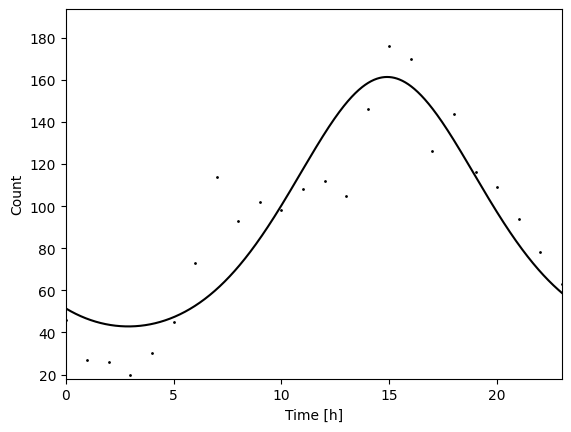

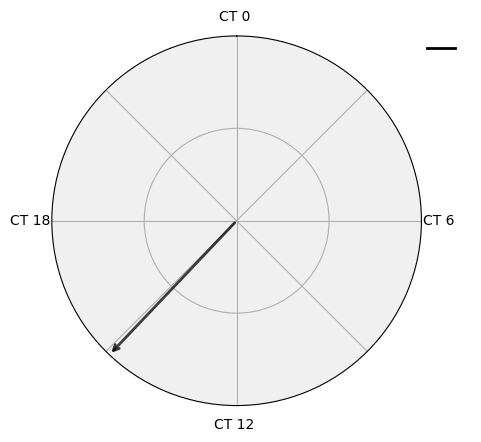

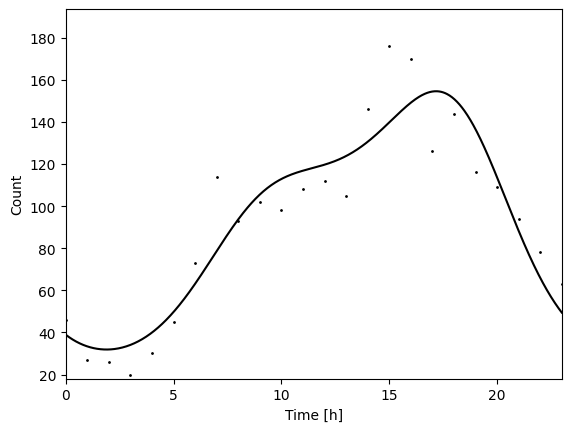

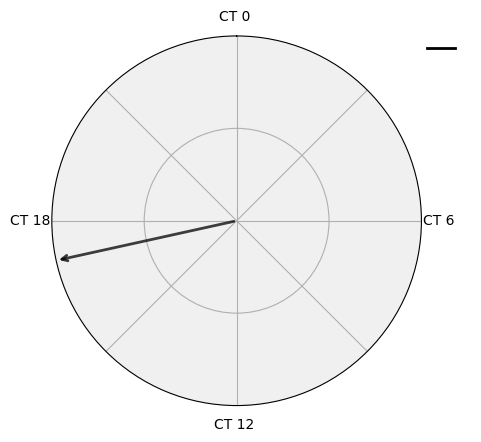

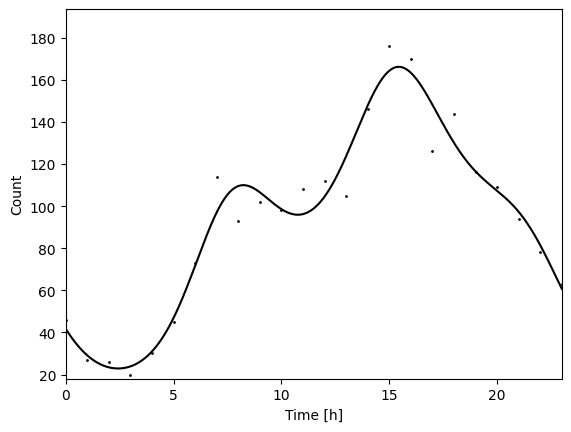

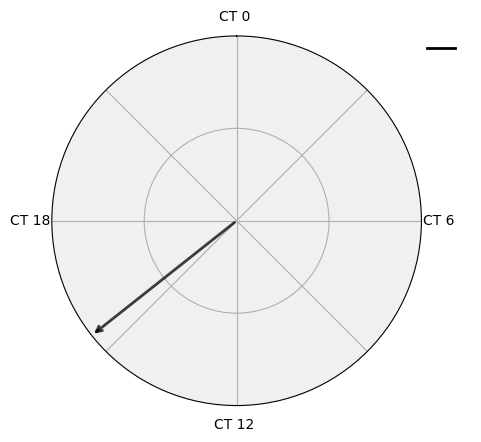

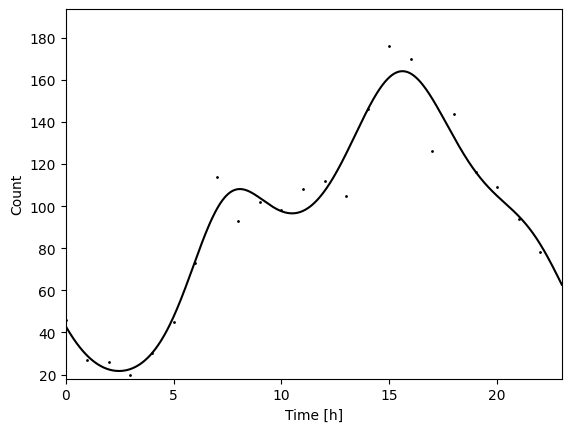

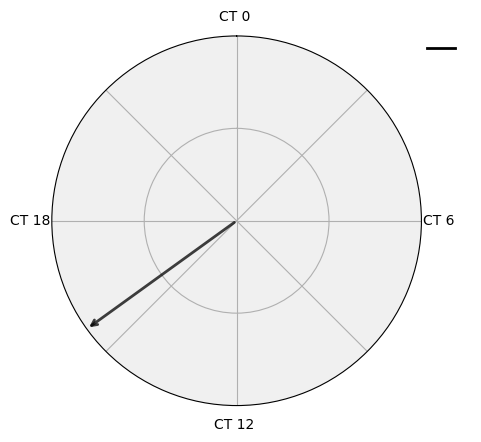

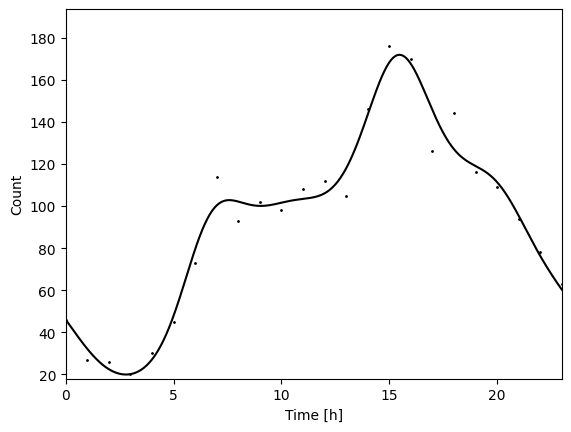

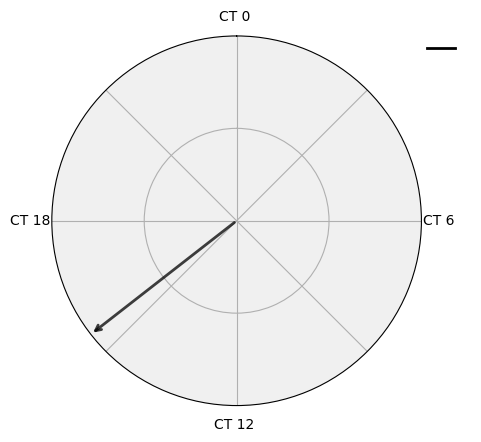

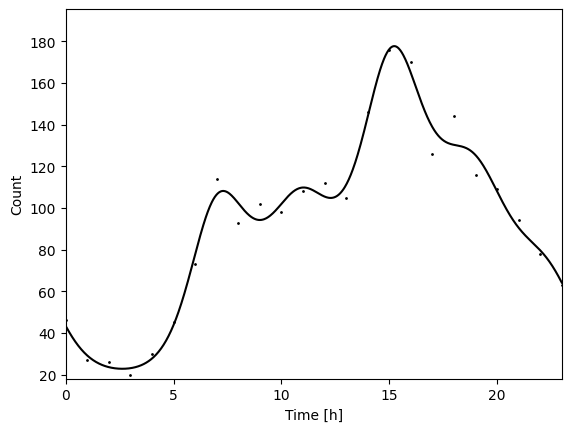

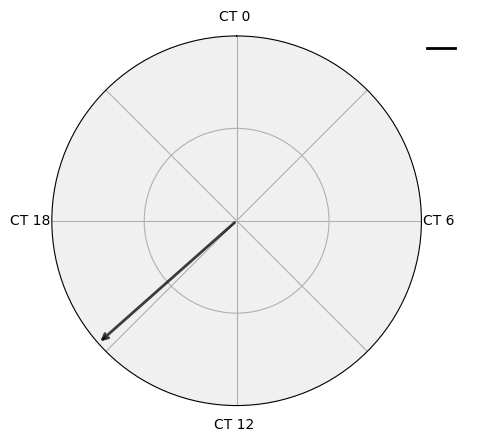

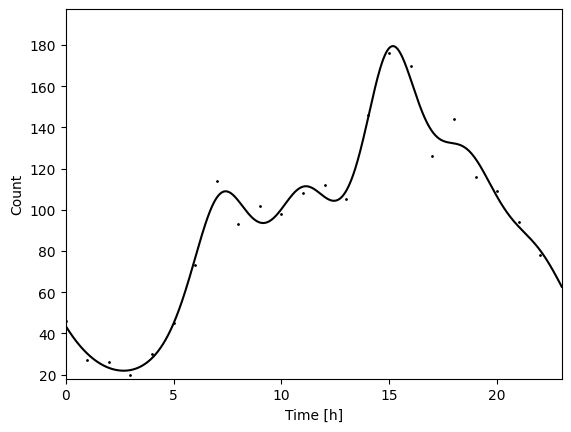

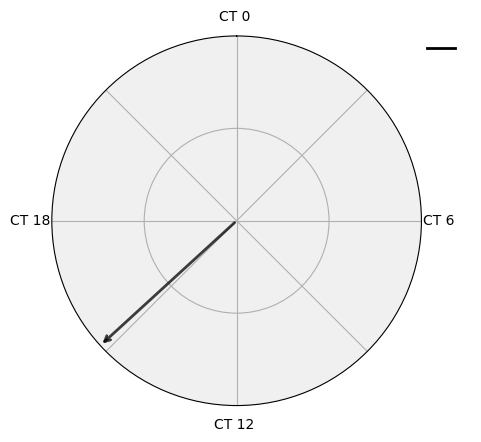

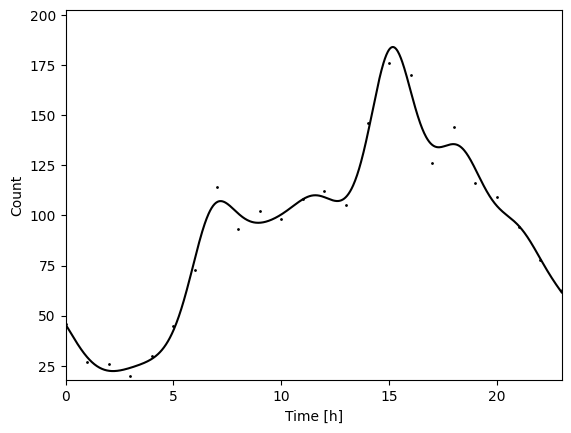

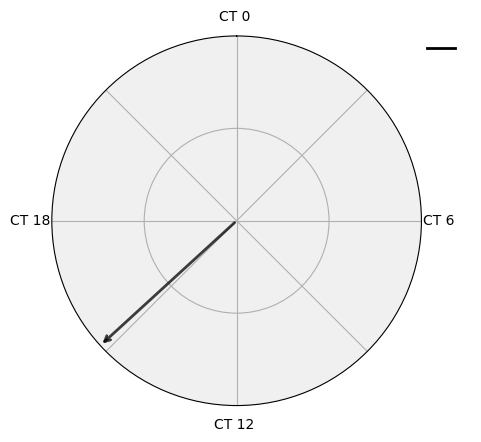

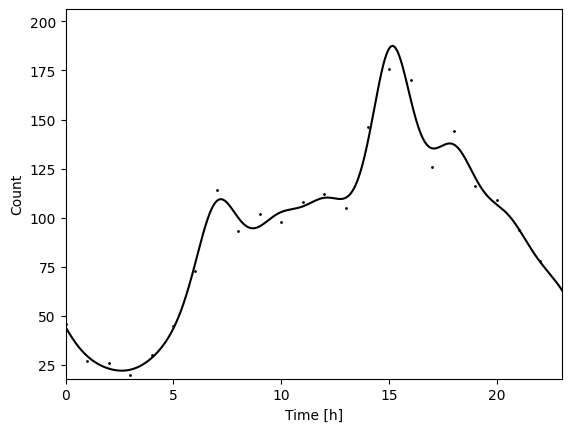

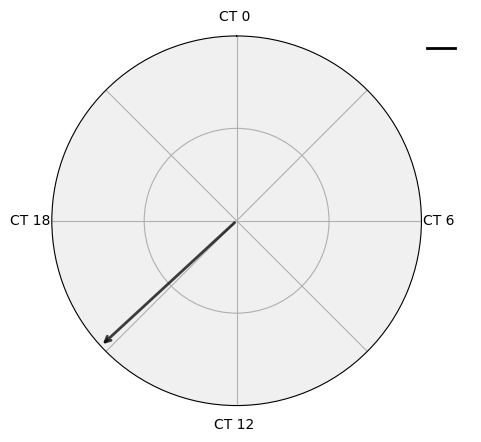

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


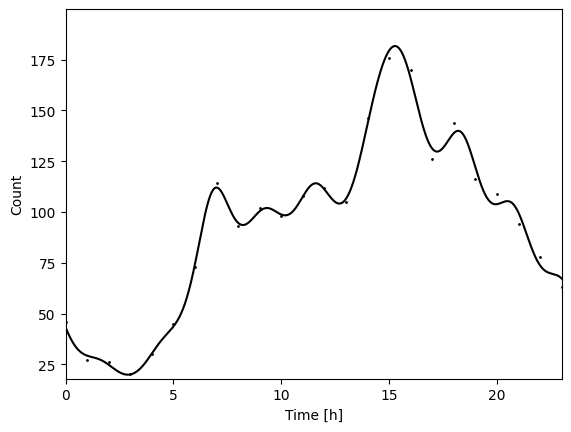

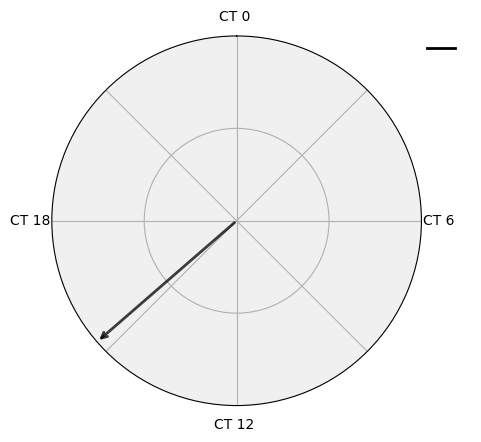

In [17]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNice', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsNice', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsNice',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [18]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsNice,24.0,1.0,1.282723e-09,1.282723e-09,9525.948411,-106.062954,0.161804,59.257342,2.382194,102.104522,[14.900690069006902],[161.3618641829353],[2.8994899489948995],[42.84718270350652],220.125908,224.838124
1,HourlyAccidentsNice,24.0,2.0,1.311978e-11,1.457753e-11,6164.742343,-98.098006,0.224750,61.357875,1.787745,93.229421,[17.171317131713174],[154.58729599381923],[1.8913891389138915],[31.871546608561324],208.196013,215.264336
2,HourlyAccidentsNice,24.0,3.0,1.960274e-16,4.512975e-16,2078.210351,-83.491115,0.340185,71.662269,2.240180,94.525516,"[8.237623762376238, 15.443144314431445]","[109.96940720104097, 166.18775122128972]",[2.4242424242424243],[22.863255409436803],182.982229,192.406660
3,HourlyAccidentsNice,24.0,4.0,1.733824e-15,2.167279e-15,2088.995849,-82.946434,0.344490,71.218613,2.196193,92.893329,"[8.074407440744075, 15.611161116111612]","[108.11538613174528, 164.11191967038914]",[2.4722472247224725],[21.674729274241646],185.892868,197.673406
4,HourlyAccidentsNice,24.0,5.0,5.603156e-16,8.004509e-16,1380.936537,-79.071180,0.375115,75.978988,2.232639,95.904332,"[7.579957995799581, 15.471947194719473]","[102.81945704912489, 171.88332056760675]",[2.793879387938794],[19.925353634170413],182.142360,196.279006
5,HourlyAccidentsNice,24.0,6.0,3.996806e-17,1.998403e-16,848.824834,-73.626015,0.418147,77.453424,2.295477,100.230189,"[7.301530153015302, 11.026702670267028, 15.231...","[108.15334503917818, 109.81029978984121, 177.6...","[2.6210621062106214, 8.996099609960996]","[22.77677093626076, 94.20680300293854]",175.252030,191.744784
6,HourlyAccidentsNice,24.0,7.0,2.064460e-16,4.512975e-16,808.226875,-73.001572,0.423082,78.777666,2.311815,100.668400,"[7.411941194119413, 11.137113711371137, 15.169...","[108.96999002944743, 111.42948959485551, 179.4...","[2.6834683468346836, 9.14971497149715]","[21.89073396169002, 93.5704307424829]",178.003144,196.852005
7,HourlyAccidentsNice,24.0,8.0,2.256487e-16,4.512975e-16,626.249455,-70.753148,0.440851,80.887876,2.311815,103.204001,"[7.186318631863187, 11.578757875787579, 15.169...","[107.17111746489053, 110.0820698320602, 184.09...","[2.1986198619861987, 8.92889288928893]","[22.316141479985834, 96.33513212339145]",177.506296,198.711265
8,HourlyAccidentsNice,24.0,9.0,4.781009e-16,7.968349e-16,636.874270,-69.346456,0.451968,82.697973,2.315585,104.798823,"[7.195919591959196, 12.135613561356136, 15.155...","[109.44047214247641, 110.26711407133718, 187.4...","[2.601860186018602, 8.684068406840685]","[22.100850521492557, 94.61788260319379]",178.692912,202.253988
9,HourlyAccidentsNice,24.0,10.0,9.970461e-19,9.970461e-18,253.299994,-59.961939,0.526132,80.887715,2.285423,100.771734,"[6.994299429942995, 9.336933693369337, 11.5979...","[112.01128686603944, 101.9286708716667, 114.09...","[2.8850885088508855, 8.223222322232225, 10.177...","[19.884022561152786, 93.5511680406016, 98.3138...",163.923879,189.841063


### Katero je najboljše število komponent

In [19]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24,3,1.960274e-16,2078.210351,-83.491115,0.340185,182.982229,192.40666,71.662269,2.24018,94.525516,"[8.237623762376238, 15.443144314431445]","[109.96940720104097, 166.18775122128972]",[2.4242424242424243],[22.863255409436803]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


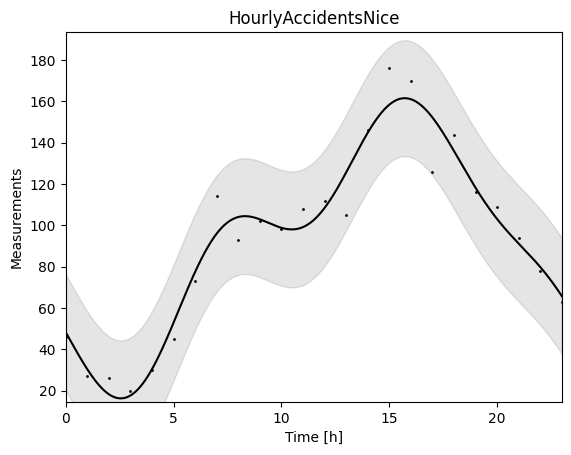

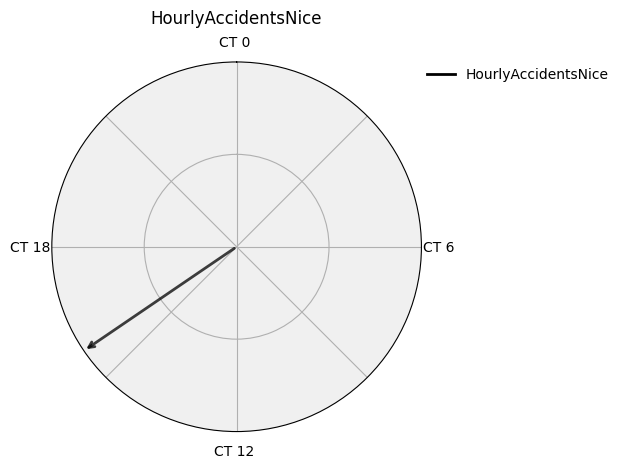

In [20]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [9]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [10]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

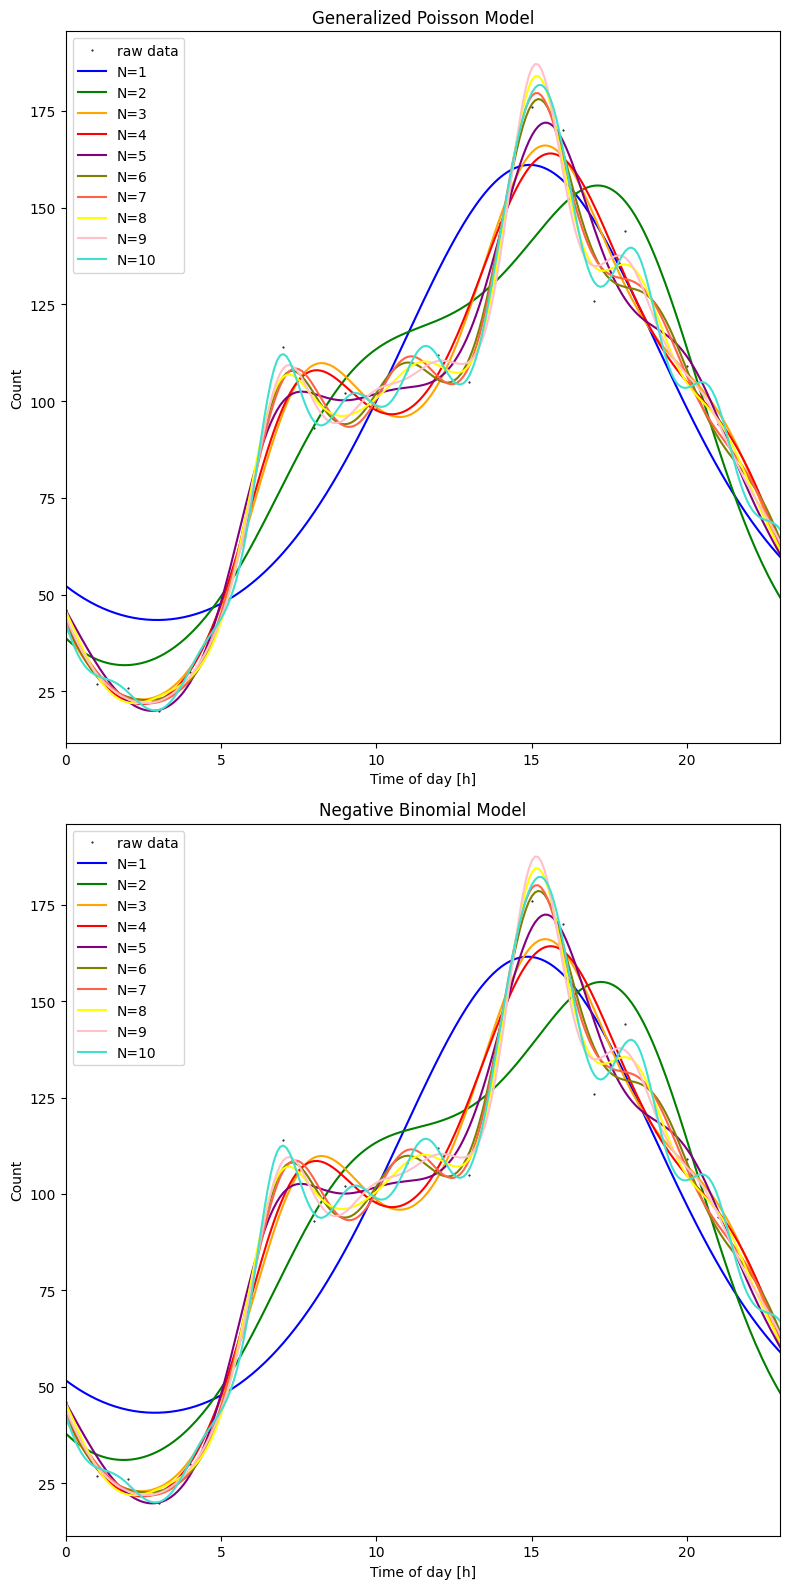

In [11]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [12]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,58.79,102.26,[14.91],[161.04],1.303852e-09,9416.517478,220.158584,224.870799,-106.079292,"[-3.671551856780077, -4.315565640162198, -4.14...",92.880069,"[52.30564459494537, 47.22983365062742, 44.3412...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[52.30564459494537, 51.69238889419226, 51.1032..."
1,gen_poisson,2,61.96,93.76,[17.12],[155.72],1.367827e-11,6168.214769,208.282322,215.350645,-98.141161,"[-3.6026463107356577, -3.226074524915237, -3.1...",92.976457,"[38.83035801778164, 33.29323260562499, 31.8179...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[38.83035801778164, 38.069287366620486, 37.357..."
2,gen_poisson,3,71.57,94.49,[15.42],[166.06],1.985435e-16,2077.451924,183.008951,192.433381,-83.504475,"[-2.974800535763137, -2.566628458896197, -2.59...",92.541667,"[41.75571396923101, 29.129694879423432, 23.465...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[41.75571396923101, 40.163687524291326, 38.642..."
3,gen_poisson,4,71.11,92.89,[15.62],[164.01],1.831031e-15,2086.108363,186.009834,197.790373,-83.004917,"[-2.8498861325295977, -2.5511516442794147, -2....",92.541667,"[42.935240927865195, 28.95939536019577, 22.478...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[42.935240927865195, 41.20468019788499, 39.542..."
4,gen_poisson,5,75.97,95.97,[15.42],[171.94],1.254799e-15,1376.738732,183.901108,198.037754,-79.950554,"[-2.7243335517994893, -3.0107617072541686, -2....",92.541667,"[46.0582389417652, 32.12577047993172, 22.48327...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[46.0582389417652, 44.60899929601082, 43.16052..."
5,gen_poisson,6,77.63,100.42,[15.22],[178.06],8.600483e-16,847.873751,182.038975,198.531729,-77.019488,"[-2.807946984738493, -2.5743178683185413, -2.5...",92.541667,"[43.46899214843375, 29.21000144389907, 23.5730...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[43.46899214843375, 41.60639243444807, 39.8324..."
6,gen_poisson,7,78.82,100.77,[15.22],[179.58],5.828820e-15,807.312291,185.542016,204.390878,-76.771008,"[-2.794053261522592, -2.6824303116317694, -2.6...",92.541667,"[43.675893300181194, 30.15008860763107, 23.256...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[43.675893300181194, 42.0093989719912, 40.4099..."
7,gen_poisson,8,81.01,103.00,[15.22],[184.01],2.083079e-14,625.875824,187.897038,209.102007,-75.948519,"[-2.7240321166293526, -2.5806228068878276, -2....",92.541667,"[45.87482688934219, 29.273989560818787, 22.161...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[45.87482688934219, 44.084265125339776, 42.278..."
8,gen_poisson,9,82.56,104.55,[15.12],[187.11],9.195894e-14,636.244275,190.994242,214.555318,-75.497121,"[-2.7546673498006697, -2.6079479114995863, -2....",92.541667,"[44.42137948000163, 29.534889585808287, 23.020...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[44.42137948000163, 42.5250433093919, 40.70210..."
9,gen_poisson,10,80.79,100.90,"[15.32, 18.22]","[181.69, 139.68]",1.066761e-13,251.807867,191.118900,217.036085,-73.559450,"[-2.8503738847859452, -2.5652546712215347, -2....",92.541667,"[42.92963462993445, 29.11506655092491, 24.8561...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[42.92963462993445, 40.41621225870742, 38.1482..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [13]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [14]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

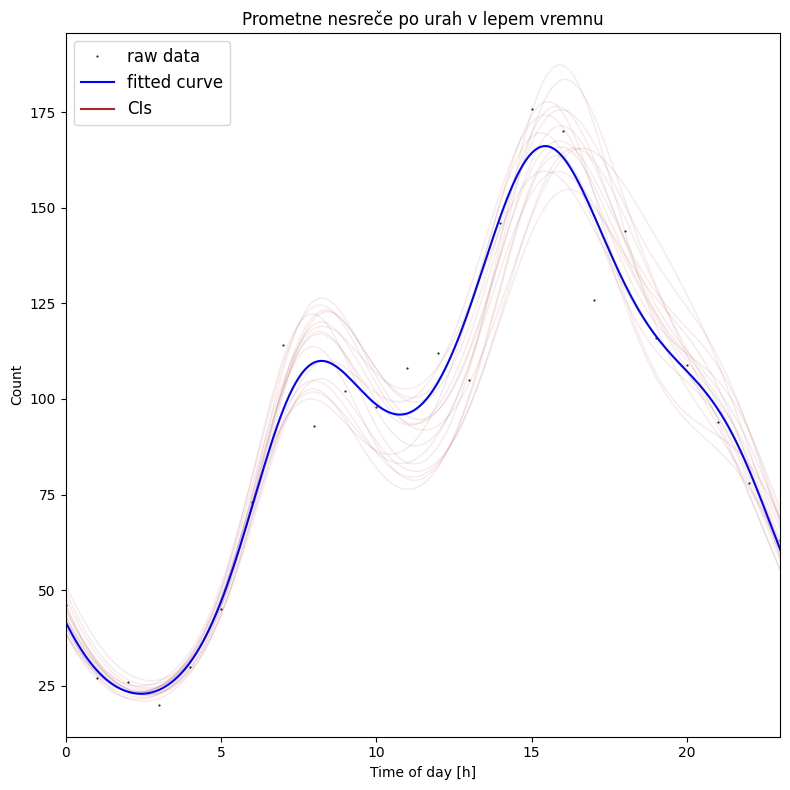

Intervali zaupanja:


,0,1
0,4.320803,4.431762
1,-0.536034,-0.422429
2,-0.662428,-0.511616
3,-0.303642,-0.168567
4,-0.279351,-0.134281
5,-0.247484,-0.123016
6,0.093442,0.203802
7,-0.531200,0.012001


In [15]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah v lepem vremnu', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [16]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,71.57
mesor,94.49
peaks,[15.42]
heights,[166.06]
amplitude_CIs,"[61.13, 82.46]"
mesor_CIs,"[84.78, 104.56]"
peaks_CIs,"[14.99, 15.96]"
heights_CIs,"[146.01, 186.92]"
